In [ ]:
pip install -U langchain umap-learn scikit-learn langchain_community tiktoken langchain-openai langchainhub chromadb langchain-anthropic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 810.5/810.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.9/273.9 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.9/262.9 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 2.5 MB/s et

In [ ]:
pip install PyMuPDF==1.23.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 33.5 MB/s eta 0:00:00


In [ ]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 224  # Fixed seed for reproducibility

### --- Code from citations referenced above (added comments and docstrings) --- ###


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neighbors: Optional; the number of neighbors to consider for each point.
                   If not provided, it defaults to the square root of the number of embeddings.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after global clustering.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - num_neighbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]


def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters


def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Perform clustering on the embeddings by first reducing their dimensionality globally, then clustering
    using a Gaussian Mixture Model, and finally performing local clustering within each global cluster.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for assigning an embedding to a cluster in GMM.

    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # Assign local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters


### --- Our code below --- ###


def embed(texts):
    """
    Generate embeddings for a list of text documents.

    This function assumes the existence of an `embd` object with a method `embed_documents`
    that takes a list of texts and returns their embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be embedded.

    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents.
    """
    text_embeddings = embd.embed_documents(texts)
    text_embeddings_np = np.array(text_embeddings)
    return text_embeddings_np


def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them, returning a DataFrame with texts, their embeddings, and cluster labels.

    This function combines embedding generation and clustering into a single step. It assumes the existence
    of a previously defined `perform_clustering` function that performs clustering on the embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings, and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # Perform clustering on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts  # Store original texts
    df["embd"] = list(text_embeddings_np)  # Store embeddings as a list in the DataFrame
    df["cluster"] = cluster_labels  # Store cluster labels
    return df


def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a DataFrame into a single string.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates embeddings for the texts,
    clusters them based on similarity, expands the cluster assignments for easier processing, and then summarizes
    the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of processing.

    Returns:
    - Tuple containing two DataFrames:
      1. The first DataFrame (`df_clusters`) includes the original texts, their embeddings, and cluster assignments.
      2. The second DataFrame (`df_summary`) contains summaries for each cluster, the specified level of detail,
         and the cluster identifiers.
    """

    # Embed and cluster the texts, resulting in a DataFrame with 'text', 'embd', and 'cluster' columns
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straightforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization
    template = """Here is a sub-set of LangChain Expression Langauge doc.

    LangChain Expression Langauge provides a way to compose chain in LangChain.

    Give a detailed summary of the documentation provided.

    Documentation:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # Format text within each cluster for summarization
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # Create a DataFrame to store summaries with their corresponding cluster and level
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary


def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarizes texts up to a specified level or until
    the number of unique clusters becomes 1, storing the results at each level.

    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys are the recursion
      levels and values are tuples containing the clusters DataFrame and summaries DataFrame at that level.
    """
    results = {}  # Dictionary to store results at each level

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Store the results of the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input texts for the next level of recursion
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # Merge the results from the next level into the current results dictionary
        results.update(next_level_results)

    return results

Loading documents from /content/data


Loading new documents: 100%|████████████████████| 92/92 [00:02<00:00, 35.74it/s]


Loaded 525 new documents from /content/data


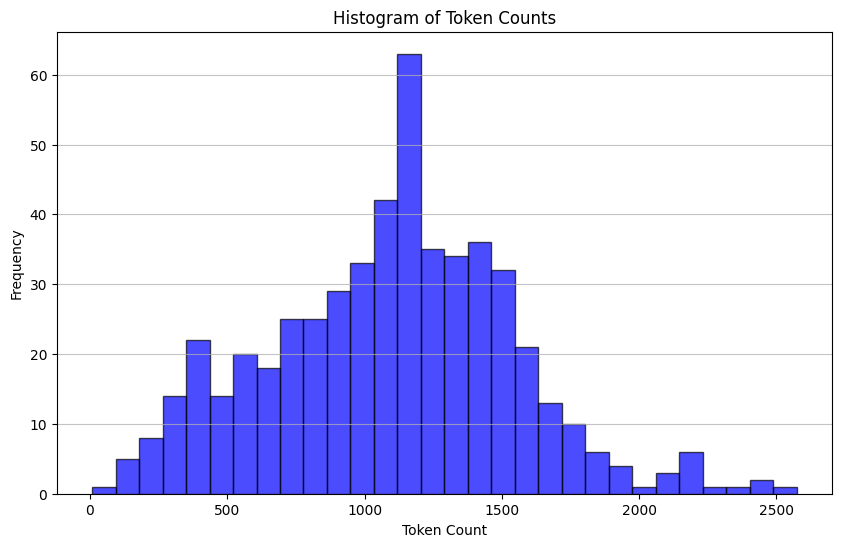

Loading new documents: 100%|████████████████████| 92/92 [00:03<00:00, 24.12it/s]


Creating embeddings for 525 text chunks...
Performing RAPTOR clustering and summarization...
--Generated 106 clusters--
--Generated 21 clusters--
--Generated 5 clusters--
Ingestion and RAPTOR processing complete!


In [ ]:
#!/usr/bin/env python3
import os
import glob
from typing import List
from multiprocessing import Pool
from tqdm import tqdm
import tiktoken
from langchain.document_loaders import (
    CSVLoader,
    EverNoteLoader,
    PyMuPDFLoader,
    TextLoader,
    UnstructuredEmailLoader,
    UnstructuredEPubLoader,
    UnstructuredHTMLLoader,
    UnstructuredMarkdownLoader,
    UnstructuredODTLoader,
    UnstructuredPowerPointLoader,
    UnstructuredWordDocumentLoader,
)
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.docstore.document import Document
import os
from chromadb.config import Settings
import matplotlib.pyplot as plt
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI

# Define the folder for storing database
PERSIST_DIRECTORY = os.environ.get('PERSIST_DIRECTORY', 'db')

# Define the Chroma settings
CHROMA_SETTINGS = Settings(
        persist_directory=PERSIST_DIRECTORY,
        anonymized_telemetry=False
)

# from raptor import recursive_embed_cluster_summarize

# Load environment variables
persist_directory = os.environ.get('PERSIST_DIRECTORY', 'db')
source_directory = os.environ.get('SOURCE_DIRECTORY', '/content/data')  # Updated to your provided path
embeddings_model_name = os.environ.get('EMBEDDINGS_MODEL_NAME', 'gpt-3.5-turbo')
# Set the environment variable (do this securely, don't hard-code in production)

# Then initialize OpenAIEmbeddings without passing the api_key directly
embd = OpenAIEmbeddings()
embeddings = OpenAIEmbeddings()
model = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")


# encoding = tiktoken.encoding_for_model(embeddings)
chunk_size = 2000
chunk_overlap = 10

# Custom document loaders
class MyElmLoader(UnstructuredEmailLoader):
    """Wrapper to fallback to text/plain when default does not work"""
    def load(self) -> List[Document]:
        try:
            try:
                doc = UnstructuredEmailLoader.load(self)
            except ValueError as e:
                if 'text/html content not found in email' in str(e):
                    self.unstructured_kwargs["content_source"] = "text/plain"
                    doc = UnstructuredEmailLoader.load(self)
                else:
                    raise
        except Exception as e:
            raise type(e)(f"{self.file_path}: {e}") from e
        return doc

LOADER_MAPPING = {
    ".csv": (CSVLoader, {}),
    ".doc": (UnstructuredWordDocumentLoader, {}),
    ".docx": (UnstructuredWordDocumentLoader, {}),
    ".enex": (EverNoteLoader, {}),
    ".eml": (MyElmLoader, {}),
    ".epub": (UnstructuredEPubLoader, {}),
    ".html": (UnstructuredHTMLLoader, {}),
    ".md": (UnstructuredMarkdownLoader, {}),
    ".odt": (UnstructuredODTLoader, {}),
    ".pdf": (PyMuPDFLoader, {}),
    ".ppt": (UnstructuredPowerPointLoader, {}),
    ".pptx": (UnstructuredPowerPointLoader, {}),
    ".txt": (TextLoader, {"encoding": "utf8"}),
}

def load_single_document(file_path: str) -> List[Document]:
    ext = "." + file_path.rsplit(".", 1)[-1]
    if ext in LOADER_MAPPING:
        loader_class, loader_args = LOADER_MAPPING[ext]
        loader = loader_class(file_path, **loader_args)
        return loader.load()
    raise ValueError(f"Unsupported file extension '{ext}'")

def load_documents(source_dir: str, ignored_files: List[str] = []) -> List[Document]:
    all_files = []
    for ext in LOADER_MAPPING:
        all_files.extend(glob.glob(os.path.join(source_dir, f"**/*{ext}"), recursive=True))
    filtered_files = [file_path for file_path in all_files if file_path not in ignored_files]

    with Pool(processes=os.cpu_count()) as pool:
        results = []
        with tqdm(total=len(filtered_files), desc='Loading new documents', ncols=80) as pbar:
            for i, docs in enumerate(pool.imap_unordered(load_single_document, filtered_files)):
                results.extend(docs)
                pbar.update()
    return results

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    # Ensure the input is a string before encoding
    if isinstance(string, str):
        num_tokens = len(encoding.encode(string))
        return num_tokens
    else:
        raise TypeError(f"Expected string, got {type(string)}")

def plot_docs(ignored_files: List[str] = []) -> List[Document]:
    print(f"Loading documents from {source_directory}")
    documents = load_documents(source_directory, ignored_files)
    if not documents:
        print("No new documents to load")
        exit(0)
    print(f"Loaded {len(documents)} new documents from {source_directory}")

    # Calculate the number of tokens for each document
    document_texts = [doc.page_content for doc in documents]

    # Calculate the number of tokens for each document text
    counts = [num_tokens_from_string(text, "cl100k_base") for text in document_texts]

    # Plotting the histogram of token counts
    plt.figure(figsize=(10, 6))
    plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
    plt.title("Histogram of Token Counts")
    plt.xlabel("Token Count")
    plt.ylabel("Frequency")
    plt.grid(axis="y", alpha=0.75)

    # Display the histogram
    plt.show()

def process_documents(ignored_files: List[str] = []) -> List[Document]:
    documents = load_documents(source_directory, ignored_files)

    # Calculate the number of tokens for each document
    document_texts = [doc.page_content for doc in documents]
    # print(document_texts[0])
    # text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    # texts = text_splitter.split_documents(document_texts)
    # print(f"Split into {len(texts)} chunks of text (max. {chunk_size} tokens each)")
    # return texts

    return document_texts

def does_vectorstore_exist(persist_directory: str) -> bool:
    if os.path.exists(os.path.join(persist_directory, 'index')):
        if os.path.exists(os.path.join(persist_directory, 'chroma-collections.parquet')) and os.path.exists(os.path.join(persist_directory, 'chroma-embeddings.parquet')):
            list_index_files = glob.glob(os.path.join(persist_directory, 'index/*.bin'))
            list_index_files += glob.glob(os.path.join(persist_directory, 'index/*.pkl'))
            if len(list_index_files) > 3:
                return True
    return False



# Process documents
plot_docs()
texts = process_documents()

# Ensure all texts are strings and handle any newlines or special characters that may cause issues
texts = [str(text).replace("\n", " ") for text in texts]

# Embedding texts using OpenAI
print(f"Creating embeddings for {len(texts)} text chunks...")
text_embeddings = embeddings.embed_documents(texts)

# Perform RAPTOR clustering and summarization
print("Performing RAPTOR clustering and summarization...")
raptor_results = recursive_embed_cluster_summarize(texts, level=1, n_levels=3)

# Further processing can be done here with `raptor_results`
print("Ingestion and RAPTOR processing complete!")

In [ ]:
from langchain_community.vectorstores import Chroma

# Initialize all_texts with leaf_texts
all_texts = texts.copy()

# Iterate through the results to extract summaries from each level and add them to all_texts
for level in sorted(raptor_results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = raptor_results[level][1]["summaries"].tolist()
    # Extend all_texts with the summaries from the current level
    all_texts.extend(summaries)

# Now, use all_texts to build the vectorstore with Chroma
vectorstore = Chroma.from_texts(texts=all_texts, embedding=embd)
retriever = vectorstore.as_retriever()

In [ ]:
from langchain import hub
from langchain_core.runnables import RunnablePassthrough

# Prompt
prompt = hub.pull("rlm/rag-prompt")


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

# Question
rag_chain.invoke("Give Guidelines to diagnose Melonoma")

'Guidelines for diagnosing melanoma include thorough diagnosis and staging, using punch biopsy techniques, determining the level of risk, and differentiating between high-risk and low-risk tumors. Treatment options for malignant melanoma in the head and neck region include immediate versus delayed reconstruction following wide local excision. Monitoring skin cancer can be done using patient self-photography, smartphone applications, and involving patients in the surveillance process while seeking expert advice when necessary.'

In [ ]:
rag_chain.invoke("Give Guidelines to treat Melonoma")

'Guidelines for treating melanoma include early recognition, biopsy, and excision of lesions, as well as the use of innovative targeted therapies and reconstructive surgery for optimal outcomes. Treatment approaches may involve the use of smoothened inhibitors and adjuvant treatments like radiation or chemotherapy for metastatic cases. Further research and systematic trials are needed to establish clear treatment modalities for advanced and metastatic melanoma.'

In [ ]:
LANGCHAIN_TRACING_V2=true
LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
LANGCHAIN_API_KEY="ls__6a928a2b77fd42819b9b194ac3a9f5a4"